In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [14]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [15]:
# Split the data into training and testing sets
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# Create simplified pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=7)),  # Fix k to reduce search space
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  # Reduce minority samples
    ('svm', SVC(probability=True, random_state=42))
])

In [17]:
# Simplified parameter grid
param_dist = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf'],  # Focus on RBF kernel
    'svm__gamma': ['scale', 'auto']
}

In [18]:
# Use RandomizedSearchCV instead of GridSearchCV
n_iter = 5  # Number of parameter settings sampled
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=3,  # Reduced from 5 to 3
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feature_selection',
                                              SelectKBest(k=7)),
                                             ('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.5)),
                                             ('svm',
                                              SVC(probability=True,
                                                  random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'svm__C': [0.1, 1, 10],
                                        'svm__gamma': ['scale', 'auto'],
                                        'svm__kernel': ['rbf']},
                   scoring='f1', verbose=1)

In [19]:
# Get best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

In [20]:
# Print model evaluation
print("\nBest Parameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     26267
           1       0.63      0.82      0.72      2577

    accuracy                           0.94     28844
   macro avg       0.81      0.89      0.84     28844
weighted avg       0.95      0.94      0.95     28844



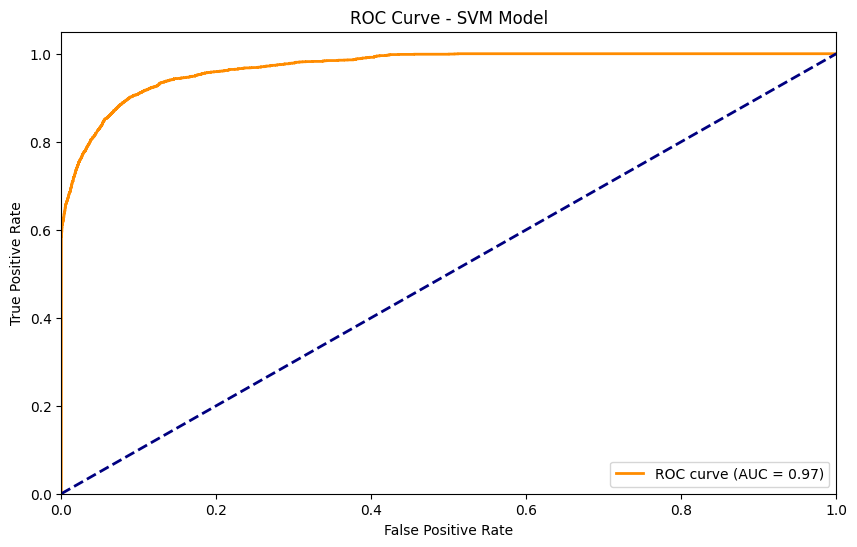

In [21]:
# Plot ROC Curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend(loc="lower right")
plt.show()

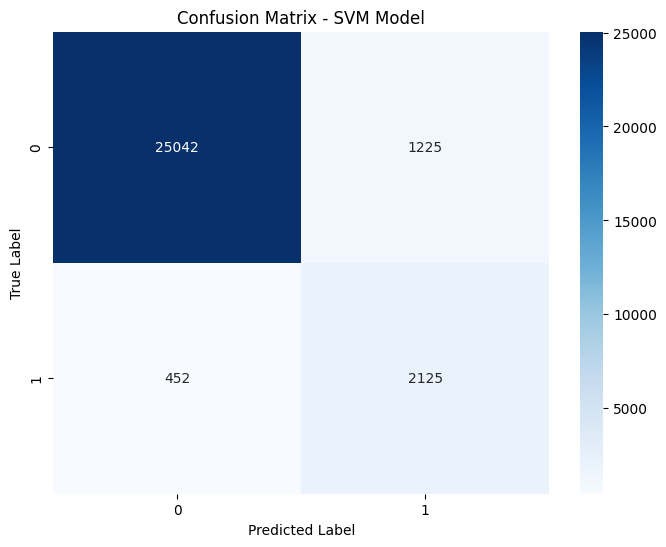

In [22]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Top Feature Importances:
               feature  importance
5          HbA1c_level    0.138683
6  blood_glucose_level    0.131556
0                  age    0.025431
4                  bmi    0.017188
2        heart_disease    0.005898
1         hypertension    0.005145
3      smoking_history    0.003815


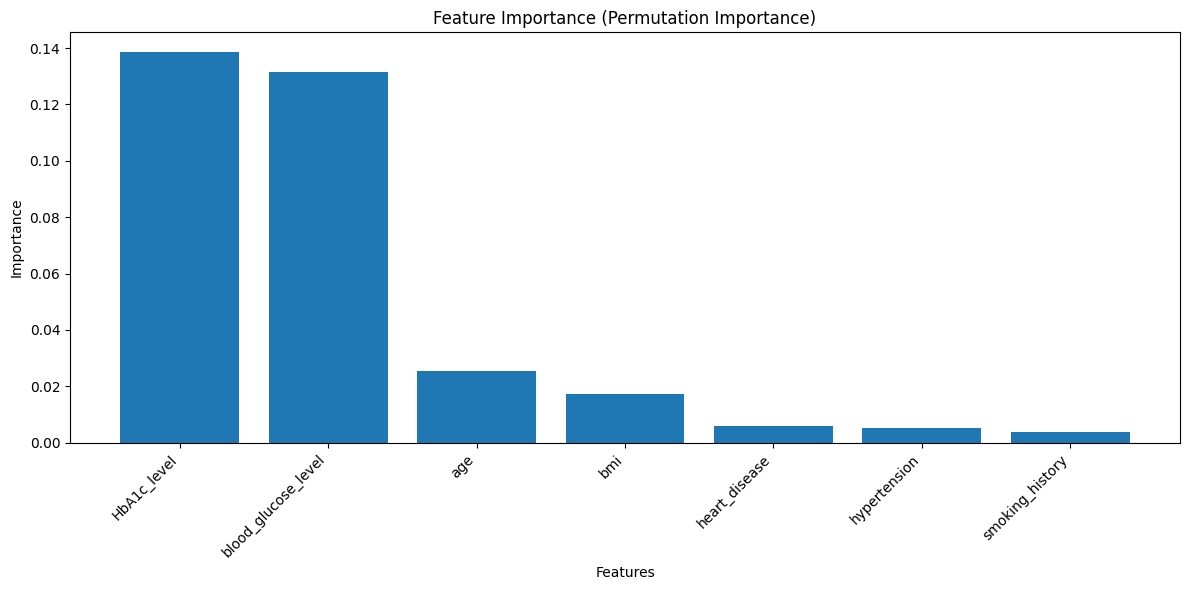

In [26]:
# Feature Importance using permutation importance
from sklearn.inspection import permutation_importance

#  Lấy các bước transform từ pipeline, ngoại trừ bước cuối cùng (SVM)
feature_pipeline = Pipeline([
    ('scaler', best_model.named_steps['scaler']),
    ('feature_selection', best_model.named_steps['feature_selection']),
    ('smote', best_model.named_steps['smote'])
])

# Transform dữ liệu test sử dụng pipeline
X_test_transformed, y_test_resampled = feature_pipeline.fit_resample(X_test, y_test)

# Lấy model SVM từ pipeline
svm_model = best_model.named_steps['svm']

# Tính permutation importance trên dữ liệu đã transform
perm_importance = permutation_importance(
    svm_model,  # Sử dụng mô hình SVM trực tiếp
    X_test_transformed,  # Dữ liệu đã được transform
    y_test_resampled,  # Target tương ứng
    n_repeats=10,
    random_state=42
)

# Lấy tên của các features được chọn
selected_mask = best_model.named_steps['feature_selection'].get_support()
selected_features = X_test.columns[selected_mask].tolist()

# Tạo DataFrame với feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': perm_importance.importances_mean
})

# Sắp xếp theo importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# In kết quả
print("\nTop Feature Importances:")
print(feature_importance)

# Visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.tight_layout()
plt.show()

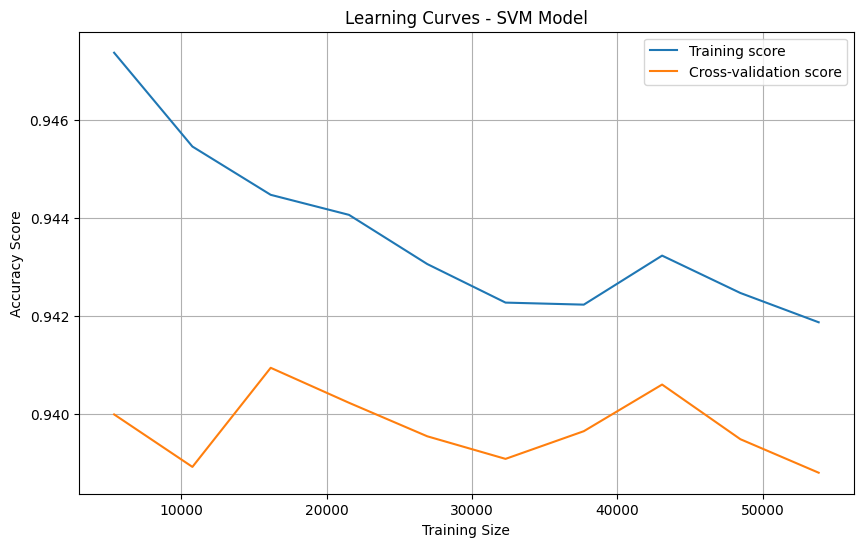

In [27]:
# Learning Curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves - SVM Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

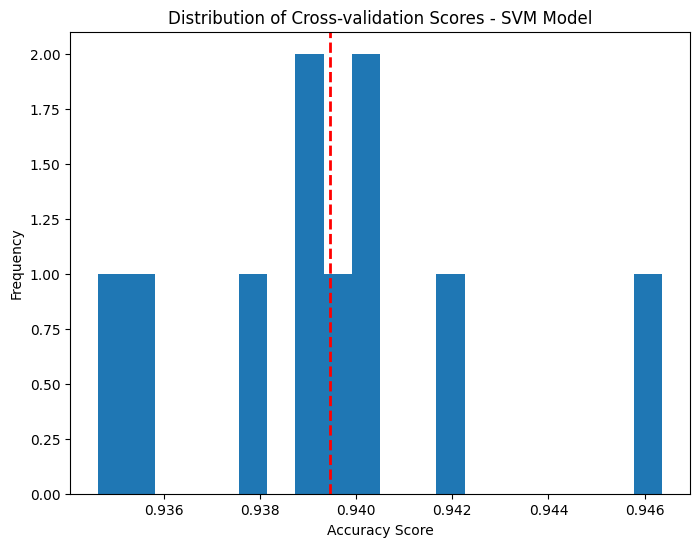


Cross-validation Scores Summary:
Mean Accuracy: 0.939 (+/- 0.006)


In [28]:
# Cross-validation Scores Distribution
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.hist(cv_scores, bins=20)
plt.axvline(cv_scores.mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cross-validation Scores - SVM Model')
plt.show()

print("\nCross-validation Scores Summary:")
print(f"Mean Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")